## Explore Stock Trading Data

For this notebook, we are going to explore stock trading data. 

Two data sets are used
- one is a "company list" dataset downloaded from <a href=http://www.nasdaq.com/screening/company-list.aspx>NASDAQ Company List</a>.

- the other one is the Google finance dataset obtained by URL https://www.google.com/finance/historical?output=csv&q=GOOG (replace `GOOG` with the ticker symbol)

The goal of this notbook is to learn how to analyze time serial data and to predict future stock price and/or trend (rise or fall).

### Load libraries

In [1]:
library(stringr)
library(plyr)
library(dplyr)
library(doParallel)
library(skmeans)
library(cluster)
library(readr)
library(tidyr)
library(ggplot2)
library(RcppRoll)
library(plotROC)
library(modelr)
library(glmnet)
library(glmnetUtils)
library(randomForest)
library(ROCR)
registerDoParallel()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loaded glmnet 2.0-13


Attaching package: ‘glmnetUtils’

The following objects are masked from ‘package:glmnet’:

    cv.glmnet, glmnet

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: gplots

Attaching packag

In [2]:
options(repr.matrix.max.rows=10,
        repr.plot.width=10,
        repr.plot.height=6)

### Load data

- ticker symbol information, which is downloaded from <a href=http://www.nasdaq.com/screening/company-list.aspx>NASDAQ Company List</a>, and preprocessed in assigment #6
- 189 stocks' daily price data

In [3]:
stock.ticker.symbols = read_csv("./stock_ticker_symbols.csv")
stock.ticker.symbols %>% head()

Parsed with column specification:
cols(
  Exchange = col_character(),
  Symbol = col_character(),
  Name = col_character(),
  LastSale = col_double(),
  MarketCap = col_double(),
  IPOyear = col_integer(),
  Sector = col_character(),
  industry = col_character()
)


Exchange,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry
NASDAQ,PIH,"1347 Property Insurance Holdings, Inc.",7.225,43.24,2014,Finance,Property-Casualty Insurers
NASDAQ,TURN,180 Degree Capital Corp.,2.058,64.05,NA,Finance,Finance/Investors Services
NASDAQ,FLWS,"1-800 FLOWERS.COM, Inc.",9.550,617.16,1999,Consumer Services,Other Specialty Stores
NASDAQ,FCCY,1st Constitution Bancorp (NJ),18.350,148.14,NA,Finance,Savings Institutions
NASDAQ,SRCE,1st Source Corporation,50.030,1300.00,NA,Finance,Major Banks
NASDAQ,VNET,"21Vianet Group, Inc.",7.240,814.50,2011,Technology,"Computer Software: Programming, Data Processing"


In [4]:
stock_trading_data = read_csv('./stock_trading_data.csv',
                              col_types='Ddddddiddc') %>%
    distinct() %>%
    filter(Date != '2017-12-12')
stock_trading_data %>% head()

Date,Open,High,Low,Close,Adjusted,Volume,Dividend,SplitCoefficient,Symbol
2017-12-08,1051.81,1056.42,1045.86,1049.38,1049.38,1479665,0,1,GOOGL
2017-12-07,1036.07,1048.92,1035.36,1044.57,1044.57,1437448,0,1,GOOGL
2017-12-06,1016.52,1039.58,1015.31,1032.72,1032.72,1369276,0,1,GOOGL
2017-12-05,1010.99,1036.68,1002.32,1019.60,1019.60,1927802,0,1,GOOGL
2017-12-04,1027.80,1031.34,1009.22,1011.87,1011.87,1896325,0,1,GOOGL
2017-12-01,1030.41,1037.24,1016.90,1025.07,1025.07,1866985,0,1,GOOGL


Check NA 

In [5]:
stock_trading_data %>%
    nrow()
stock_trading_data %>%
    drop_na() %>%
    nrow()

[1] 92565

[1] 92565

No NA exists, which is good!

### Stats

Raw data stats

In [6]:
summary(stock_trading_data)

      Date                 Open              High               Low          
 Min.   :2011-06-28   Min.   :   0.13   Min.   :   0.138   Min.   :   0.111  
 1st Qu.:2016-06-16   1st Qu.:  16.55   1st Qu.:  16.863   1st Qu.:  16.260  
 Median :2016-12-13   Median :  50.65   Median :  51.060   Median :  50.200  
 Mean   :2016-12-12   Mean   : 102.17   Mean   : 103.163   Mean   : 101.129  
 3rd Qu.:2017-06-14   3rd Qu.:  99.23   3rd Qu.:  99.990   3rd Qu.:  98.400  
 Max.   :2017-12-11   Max.   :4650.00   Max.   :4690.000   Max.   :4572.000  
     Close             Adjusted            Volume             Dividend       
 Min.   :   0.131   Min.   :   0.251   Min.   :        0   Min.   :0.000000  
 1st Qu.:  16.560   1st Qu.:  16.078   1st Qu.:   240803   1st Qu.:0.000000  
 Median :  50.640   Median :  48.210   Median :  1225338   Median :0.000000  
 Mean   : 102.201   Mean   : 100.222   Mean   :  4192335   Mean   :0.004969  
 3rd Qu.:  99.220   3rd Qu.:  95.754   3rd Qu.:  3952637   3rd Q

How many stocks do we have in this data?

In [7]:
stock_trading_data %>%
    select(Symbol) %>%
    distinct() %>%
    nrow()

[1] 189

Stats for each stock

In [8]:
stats_stock_trading = stock_trading_data %>%
    group_by(Symbol) %>%
    summarize(count=n(),
              minOpen = min(Open),
              maxOpen = max(Open),
              meanOpen = mean(Open),
              minClose = min(Close),
              maxClose = max(Close),
              meanClose = mean(Close)) %>%
    ungroup()
stats_stock_trading

Symbol,count,minOpen,maxOpen,meanOpen,minClose,maxClose,meanClose
AAL,499,26.12,54.21,42.56842,25.27,54.22,42.57960
AAPL,499,90.00,175.11,125.77895,90.34,176.24,125.85820
ABB,499,15.96,26.47,22.01408,16.06,26.28,22.03834
ABBV,499,51.32,97.19,66.78260,51.18,96.92,66.87611
ACN,499,92.54,149.10,119.65364,93.32,150.53,119.78940
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
WFC,498,43.6200,59.78,51.750382,43.75,59.73,51.771386
WMT,498,58.8200,99.24,73.252329,58.85,99.62,73.328775
WWD,499,43.1400,81.57,63.567856,42.91,82.05,63.606894
XOM,499,73.1600,95.44,83.922986,73.18,95.12,83.951543


In [9]:
summary(stats_stock_trading %>% select(-Symbol))

     count          minOpen             maxOpen           meanOpen       
 Min.   : 65.0   Min.   :   0.1301   Min.   :   1.03   Min.   :   0.526  
 1st Qu.:499.0   1st Qu.:  11.5300   1st Qu.:  24.50   1st Qu.:  16.597  
 Median :499.0   Median :  37.0200   Median :  63.57   Median :  51.750  
 Mean   :489.8   Mean   :  71.8283   Mean   : 132.53   Mean   : 100.826  
 3rd Qu.:499.0   3rd Qu.:  73.1600   3rd Qu.: 124.99   3rd Qu.:  96.192  
 Max.   :499.0   Max.   :2500.0100   Max.   :4650.00   Max.   :3614.915  
    minClose            maxClose         meanClose       
 Min.   :   0.1306   Min.   :   1.00   Min.   :   0.523  
 1st Qu.:  11.6900   1st Qu.:  24.00   1st Qu.:  16.610  
 Median :  37.2000   Median :  63.72   Median :  51.771  
 Mean   :  72.0107   Mean   : 132.49   Mean   : 100.853  
 3rd Qu.:  73.1800   3rd Qu.: 125.41   3rd Qu.:  96.206  
 Max.   :2483.0000   Max.   :4654.08   Max.   :3614.653  

In [10]:
stock.ticker.symbols

Exchange,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry
NASDAQ,PIH,"1347 Property Insurance Holdings, Inc.",7.225,43.24,2014,Finance,Property-Casualty Insurers
NASDAQ,TURN,180 Degree Capital Corp.,2.058,64.05,NA,Finance,Finance/Investors Services
NASDAQ,FLWS,"1-800 FLOWERS.COM, Inc.",9.550,617.16,1999,Consumer Services,Other Specialty Stores
NASDAQ,FCCY,1st Constitution Bancorp (NJ),18.350,148.14,NA,Finance,Savings Institutions
NASDAQ,SRCE,1st Source Corporation,50.030,1300.00,NA,Finance,Major Banks
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
NYSE,ZBK,Zions Bancorporation,29.4844,NA,NA,Finance,Major Banks
NYSE,ZOES,"Zoe&#39;s Kitchen, Inc.",13.3700,261.45,2014,Consumer Services,Restaurants
NYSE,ZTS,Zoetis Inc.,71.2900,34740.00,2013,Health Care,Major Pharmaceuticals
NYSE,ZTO,ZTO Express (Cayman) Inc.,16.4700,11820.00,2016,Transportation,Trucking Freight/Courier Services


Create metadata

In [11]:
stock_metadata = stock.ticker.symbols %>% select(Symbol, Sector, industry) %>% distinct()
stock_metadata

Symbol,Sector,industry
PIH,Finance,Property-Casualty Insurers
TURN,Finance,Finance/Investors Services
FLWS,Consumer Services,Other Specialty Stores
FCCY,Finance,Savings Institutions
SRCE,Finance,Major Banks
⋮,⋮,⋮
ZBK,Finance,Major Banks
ZOES,Consumer Services,Restaurants
ZTS,Health Care,Major Pharmaceuticals
ZTO,Transportation,Trucking Freight/Courier Services


Make a sample data

when all codes runing without problems, set sampleSize to full size

In [12]:
sampleSize = 10
sample.stock.trading.data = stock_trading_data %>%
    select(Symbol) %>%
    distinct() %>%
    sample_n(sampleSize) %>%
    inner_join(stock_trading_data)
sample.stock.trading.data

Joining, by = "Symbol"


Symbol,Date,Open,High,Low,Close,Adjusted,Volume,Dividend,SplitCoefficient
BTG,2017-12-08,2.58,2.630,2.56,2.62,2.62,2081536,0,1
BTG,2017-12-07,2.58,2.620,2.55,2.59,2.59,3083400,0,1
BTG,2017-12-06,2.54,2.640,2.54,2.61,2.61,4375879,0,1
BTG,2017-12-05,2.58,2.610,2.55,2.55,2.55,2245029,0,1
BTG,2017-12-04,2.60,2.625,2.59,2.60,2.60,1742898,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FAX,2015-12-23,4.58,4.630,4.58,4.615,3.8897,950673,0,1
FAX,2015-12-22,4.56,4.590,4.55,4.580,3.8602,1258590,0,1
FAX,2015-12-21,4.52,4.580,4.52,4.570,3.8518,904610,0,1
FAX,2015-12-18,4.52,4.550,4.50,4.530,3.8181,1346693,0,1


### Research Questions and Prediction Objectives

1. What stocks do have the similar trending during a certain period?

- What is the top 10 stocks which have the greastest increase or decrease during a certain period over all stocks or for each sector seperately?  

- What is the probability of rise or fall after continuously rising or falling for a certain amount of days? Consider it over all stocks, stocks in each sector , or several selected stocks seperately.

- After how many days of continously rising or falling is the probability of rise or fall highest?

- Predict next day's trend (rise or fall) using previous days' price and volume variables. Different day number and variables will be tried.

- Predict next day's price using previous days' features.

- Build a trading simulation to trade stocks using the best trained model (optional).

###  Section 1

**What stocks do have the similar trending during a certain period?**

For each stock, we have five features: `Close`, `High`, `Low`, `Open`, `Volume`. So the values of these feature construct a feature vector for a stock in one day. We are going to combine several days' data vector togother to form a long vector to represent a feature vector for a stock in several days. Then across all stocks or stocks in each sector, for a certain several days, a K-Mean clustering algorithm can be used to cluster stocks. Then stocks with similar trending may be grouped together.

Create dataframe we need
- `gather` these five features and `spread` by `Symbol` to convert each column to a continuous time stock price for each `Symbol`
- `select` a certain period and `transpose` the matrix to get it ready for `skmeans`

In [13]:
stock.trading.time.tall = sample.stock.trading.data %>%
    select(Date, Symbol, Open, High, Low, Close, Volume) %>%
    gather('Type', 'Value', -one_of(c('Date','Symbol'))) %>%
    mutate(Type = factor(Type, levels = c('Open', 'High', 'Low', 'Close', 'Volume'))) %>%
    spread(Symbol, Value, fill=0) %>%
    arrange(Date, Type)
stock.trading.time.tall

Date,Type,CAJ,CEF,CMT,DLA,GT,IMO,MCD,NSC,ORCL,XOM
2015-12-17,Open,30.43,9.93,13.10,15.9200,33.2000,30.39,118.34,0,0,79.02
2015-12-17,High,30.49,9.95,13.10,15.9200,33.5092,30.66,118.90,0,0,79.23
2015-12-17,Low,30.12,9.84,12.25,15.8582,32.4000,30.11,117.49,0,0,77.95
2015-12-17,Close,30.13,9.93,12.50,15.8582,32.5000,30.48,117.50,0,0,77.96
2015-12-17,Volume,265811.00,1147107.00,21452.00,1416.0000,2067282.0000,416058.00,5275921.00,0,0,17362915.00
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2017-12-08,Open,38.45,12.69,20.26,19.83,31.55,31.05,173.0500,141.56,48.90,82.75
2017-12-08,High,38.48,12.78,20.46,20.25,31.85,31.05,173.5429,142.76,49.69,82.90
2017-12-08,Low,38.20,12.68,19.74,19.60,31.45,30.65,172.5100,140.62,48.70,82.26
2017-12-08,Close,38.35,12.69,20.07,19.81,31.75,30.73,173.1500,140.82,49.60,82.66


In this dataframe, every five rows are the stock data for one day

Select data in Nov. 2017

In [14]:
stock.nov = stock.trading.time.tall %>%
    filter(Date >= '2017-11-01', Date < '2017-12-01') %>%
    select(-one_of(c('Date', 'Type'))) %>%
    t()
stock.nov

CAJ,37.89,37.8900,37.48,37.69,230535,37.64,37.74,37.56,37.73,145767,⋯,38.610,38.64,38.2000,38.31,118351,38.47,38.4800,38.339,38.37,110021
CEF,13.21,13.3000,13.17,13.24,812247,13.25,13.36,13.24,13.24,477007,⋯,13.220,13.26,13.1400,13.17,652305,13.07,13.1318,13.000,13.12,1108479
CMT,23.15,23.4000,23.01,23.08,18867,22.90,23.31,21.00,22.33,40585,⋯,22.385,22.69,22.0401,22.69,8741,22.61,22.6100,21.510,21.52,14378
DLA,21.17,21.1700,20.90,20.93,7837,20.90,21.21,20.76,21.21,11928,⋯,21.110,21.35,20.2380,20.43,52471,20.85,20.8500,20.250,20.25,17458
GT,30.18,30.7300,30.14,30.23,3873026,30.22,30.22,29.38,29.94,4514215,⋯,31.830,32.43,31.7100,32.14,3092417,32.25,32.6900,32.250,32.37,3181421
IMO,32.43,32.7523,31.98,32.23,293589,30.35,31.14,30.35,30.57,809316,⋯,30.900,30.98,30.5600,30.76,166511,30.81,31.1999,30.750,30.93,175456
MCD,165.72,167.9900,165.57,166.37,2177821,166.99,168.47,166.50,168.10,2282869,⋯,171.700,172.02,169.0500,170.43,4590301,170.24,173.1700,169.340,171.97,6023705
NSC,132.45,132.4500,130.72,131.84,978442,130.80,132.22,129.97,132.15,1228470,⋯,130.590,137.22,130.1747,136.41,3635155,136.03,139.9800,135.180,138.63,3097750
ORCL,51.10,51.1700,50.57,50.64,10064430,50.54,50.70,50.12,50.28,10348803,⋯,48.850,48.86,48.2000,48.52,14377575,48.89,49.3300,48.890,49.06,24701096
XOM,83.39,83.9400,83.26,83.87,9234038,83.60,83.71,82.91,83.53,7729028,⋯,81.650,82.31,81.4800,82.27,9724992,82.45,83.4000,82.410,83.29,18592679


Cluster it to 5 groups

In [15]:
stock_nov_skmeans = skmeans(stock.nov, 5)

In [16]:
stock_nov_skmeans

A hard spherical k-means partition of 10 objects into 5 classes.
Class sizes: 1, 1, 4, 3, 1
Call: skmeans(x = stock.nov, k = 5)

In [17]:
stock_nov_skmeans$cluster

CAJ  CEF  CMT  DLA   GT  IMO  MCD  NSC ORCL  XOM 
   4    1    4    5    4    2    3    3    3    3

Use **_Sihouette_** to evaluate the quality of clusters. The **_Sihouette_** is computed by:

$$s(i) = \frac{L(i) - A(i)}{Max \{L(i), A(i) \}}, -1 <= s(i) <=1$$

- $L(i)$ is the smallest average distance of point i to all points of other clusters
- $A(i)$ is the average distance of i to other points in the cluster to which point i belongs 

In [18]:
sihouette_stock_nov_skmeans = silhouette(stock_nov_skmeans)

Summary

The silhouete widths is average widths in each cluster

In [19]:
summary_sihouette_stock_nov_skmeans = summary(sihouette_stock_nov_skmeans)
summary_sihouette_stock_nov_skmeans

Silhouette of 10 units in 5 clusters from silhouette.skmeans(x = stock_nov_skmeans) :
 Cluster sizes and average silhouette widths:
        1         1         4         3         1 
      Inf 0.0000000 0.5314994 0.1539636 0.0000000 
Individual silhouette widths:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1058  0.2606     Inf  0.5718     Inf 

We can access the one with maximal _Sihouette Value_ (Not Inf) by following way

In [20]:
mean_summary_sihouette_stock_nov_skmeans = summary_sihouette_stock_nov_skmeans[[2]]
which.max(mean_summary_sihouette_stock_nov_skmeans[mean_summary_sihouette_stock_nov_skmeans != Inf])

3 
2

Cluster 2 has the maximal average Sihouette Value, which means points in cluster 2 are best grouped.

In [21]:
cluster.one = names(stock_nov_skmeans$cluster[stock_nov_skmeans$cluster == 2])
cluster.one

[1] "IMO"

We can also plot it

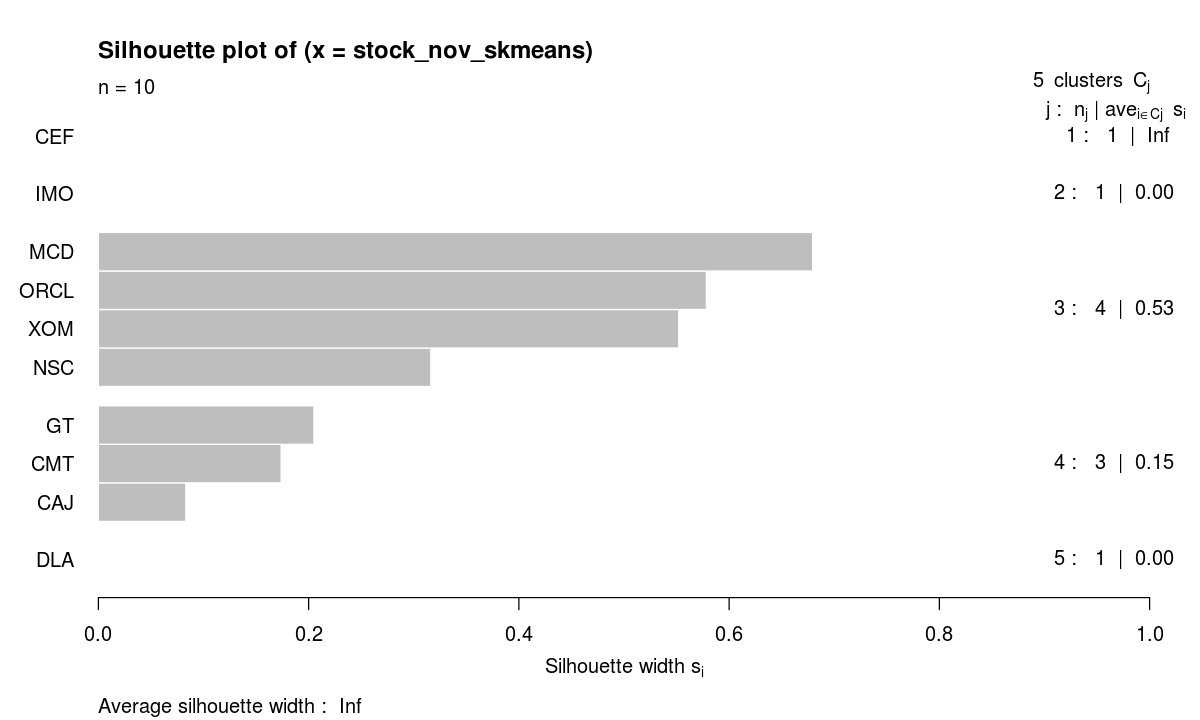

In [22]:
plot(sihouette_stock_nov_skmeans)

**Do this analysis on a year period**

1. create time window (weekly), 
2. cluster data in each window (weekly), 
3. select the cluster with the maximal average sihouette,
4. use stocks in that cluster to represent the most similar stocks in that period(week) 

How many days do we have data in 2017

In [23]:
stock.trading.time.tall %>%
    filter(Date >= '2017-01-01') %>%
    nrow() / 5

[1] 237

Remove last twodays, and group each five days into a week to make a week number

In [24]:
stock.trading.2017.tall = stock.trading.time.tall %>%
    filter(Date >= '2017-01-01', Date < '2017-12-07') %>%
    mutate(weekNum = (row_number() - 1)%/%25 + 1)
stock.trading.2017.tall

Date,Type,CAJ,CEF,CMT,DLA,GT,IMO,MCD,NSC,ORCL,XOM,weekNum
2017-01-03,Open,28.180,11.35,17.090,21.170,31.040,35.150,121.86,108.91,38.45,90.94,1
2017-01-03,High,28.435,11.68,17.145,21.330,31.826,35.425,122.00,109.52,38.69,91.34,1
2017-01-03,Low,28.150,11.35,16.420,20.995,30.950,34.780,118.96,106.15,38.30,90.15,1
2017-01-03,Close,28.420,11.61,16.570,21.140,31.190,35.030,119.62,106.99,38.55,90.89,1
2017-01-03,Volume,562414.000,1054613.00,20010.000,33737.000,2704661.000,170322.000,5123752.00,1770074.00,11051341.00,10360622.00,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2017-12-06,Open,37.91,12.87,20.50,20.03,32.14,31.10,173.39,138.77,47.880,83.08,47
2017-12-06,High,38.08,12.92,20.56,20.73,32.27,31.45,174.44,139.52,48.585,83.20,47
2017-12-06,Low,37.89,12.84,20.13,20.03,31.31,30.97,173.00,138.36,47.630,82.21,47
2017-12-06,Close,38.05,12.87,20.28,20.03,31.36,31.02,173.48,138.73,48.420,82.28,47


Combine all in the example, and write a function

In [25]:
get_similar_stocks = function(stockTradingTall, clusterNum) {
    weekNum = unique(stockTradingTall$weekNum)
    stockKMeanFeatures = stockTradingTall %>%
        select(-one_of(c('Date', 'Type', 'weekNum'))) %>%
        t()
    stockKMean = skmeans(stockKMeanFeatures, clusterNum)
    meanSihouetteClusters = summary(silhouette(stockKMean))[[2]]
    maxClusterNum = which.max(meanSihouetteClusters[meanSihouetteClusters != Inf])
    maxSihouetteValue = max(meanSihouetteClusters[meanSihouetteClusters != Inf])
    stockSymbols = names(stockKMean$cluster[stockKMean$cluster == maxClusterNum])
    data.frame(Symbols = stockSymbols,
               `weekNum` = weekNum,
               maxSiValue = maxSihouetteValue)
}

In [26]:
most.similar.stocks.weekly = ddply(stock.trading.2017.tall, .(weekNum), get_similar_stocks, 5)

Select the week with max "Maximal Sihouette" value over weeks to plot

In [27]:
mostSimilarWeekNum = most.similar.stocks.weekly %>%
    select(weekNum, maxSiValue) %>%
    distinct() %>%
    arrange(-maxSiValue) %>%
    head(1) %>%
    .$weekNum
most.similar.stocks.over.week = most.similar.stocks.weekly %>%
    filter(weekNum == mostSimilarWeekNum)
most.similar.stocks.over.week

Symbols,weekNum,maxSiValue
GT,37,0.9870702
MCD,37,0.9870702


In [28]:
data.for.plot = stock.trading.2017.tall %>%
    select(Date, Type, weekNum, one_of(as.character(most.similar.stocks.over.week$Symbols))) %>%
    gather('Stock', 'Value', as.character(most.similar.stocks.over.week$Symbols)) %>%
    filter(weekNum == unique(most.similar.stocks.over.week$weekNum))

In [29]:
data.for.plot

Date,Type,weekNum,Stock,Value
2017-09-20,Open,37,GT,32.19
2017-09-20,High,37,GT,32.42
2017-09-20,Low,37,GT,31.96
2017-09-20,Close,37,GT,32.27
2017-09-20,Volume,37,GT,2190944.00
⋮,⋮,⋮,⋮,⋮
2017-09-26,Open,37,MCD,156.25
2017-09-26,High,37,MCD,156.84
2017-09-26,Low,37,MCD,153.27
2017-09-26,Close,37,MCD,153.35


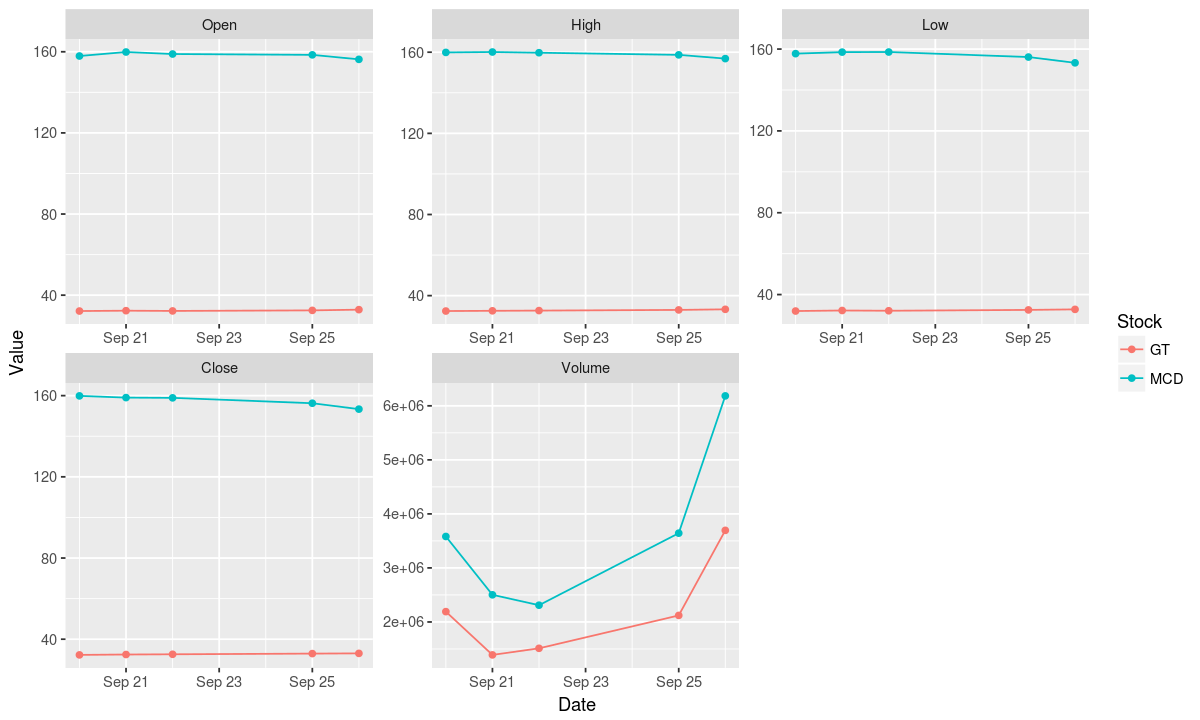

In [30]:
ggplot(data.for.plot) +
    aes(x = Date, y = Value, color = Stock) +
    geom_line() +
    geom_point() +
    facet_wrap(~Type, scales = 'free')

Very much stable two stocks! But they do close to each other in this week! Also the sKmean uses angle to evaluate the similarity, this makes the algorithm better caputer the change of stocks rather than the amplitude.

### Section 2

**What is the top 10 stocks which have the greatest increase or decrease during a certain period over all stocks?**

For a cetain period, only considering the values of one of the features (like Close) at the beginning and last day, the relative difference of the values can be used to rank stocks.

Select Close Price and Compute the greatest increase/decrease by:

$$IncreaseRate = \frac{Close_{last} - Close_{first}}{Close_{first}}$$

**Yearly**

The top 10 stocks see the greatest increase and decrease in 2017

In [31]:
stock.change.2017 = bind_cols(stock.trading.2017.tall %>%
    filter(Type == 'Close') %>%
    head(1) %>%
    select(-one_of(c('Date', 'Type', 'weekNum'))) %>%
    gather('Stock', 'CloseFirst'),
    stock.trading.2017.tall %>%
    filter(Type == 'Close') %>%
    tail(1) %>%
    select(-one_of(c('Date', 'Type', 'weekNum'))) %>%
    gather('Stock', 'CloseLast') %>%
         select(-Stock)) %>%
    mutate(IncreaseRate = (CloseLast - CloseFirst) / CloseFirst) %>%
    arrange(-IncreaseRate)
stock.change.2017

Stock,CloseFirst,CloseLast,IncreaseRate
MCD,119.62,173.48,0.450259154
CAJ,28.42,38.05,0.338845883
NSC,106.99,138.73,0.296663240
ORCL,38.55,48.42,0.256031128
CMT,16.57,20.28,0.223898612
CEF,11.61,12.87,0.108527132
GT,31.19,31.36,0.005450465
DLA,21.14,20.03,-0.052507096
XOM,90.89,82.28,-0.094729893
IMO,35.03,31.02,-0.114473309


Top 10 increase

In [32]:
stock.change.2017 %>%
    head(10) %>%
    .$Stock

[1] "MCD"  "CAJ"  "NSC"  "ORCL" "CMT"  "CEF"  "GT"   "DLA"  "XOM"  "IMO"

Top 10 decrease

In [33]:
stock.change.2017 %>%
    arrange(IncreaseRate) %>%
    head(10) %>%
    .$Stock

[1] "IMO"  "XOM"  "DLA"  "GT"   "CEF"  "CMT"  "ORCL" "NSC"  "CAJ"  "MCD"

Do this again monthly and weekly

In [34]:
stock.trading.close = stock.trading.2017.tall %>%
    mutate(monthNum = (weekNum - 1)%/% 4 + 1) %>%
    filter(Type == 'Close') %>%
    gather('Stock', 'Price', -one_of(c('Date', 'Type', 'weekNum', 'monthNum')))
stock.trading.close

Date,Type,weekNum,monthNum,Stock,Price
2017-01-03,Close,1,1,CAJ,28.42
2017-01-04,Close,1,1,CAJ,28.70
2017-01-05,Close,1,1,CAJ,28.89
2017-01-06,Close,1,1,CAJ,28.56
2017-01-09,Close,1,1,CAJ,28.55
⋮,⋮,⋮,⋮,⋮,⋮
2017-11-30,Close,47,12,XOM,83.29
2017-12-01,Close,47,12,XOM,83.46
2017-12-04,Close,47,12,XOM,83.57
2017-12-05,Close,47,12,XOM,82.89


**Monthly**

In [35]:
stock.change.monthly = stock.trading.close %>%
    group_by(Stock, monthNum) %>%
    summarize(CloseFirst = Price[which.min(Date)]) %>%
    ungroup() %>%
    inner_join(stock.trading.close %>%
               group_by(Stock, monthNum) %>%
               summarize(CloseLast = Price[which.max(Date)]) %>%
               ungroup()) %>%
    mutate(IncreaseRate = (CloseLast - CloseFirst) / CloseFirst) %>%
    arrange(monthNum, -IncreaseRate)
stock.change.monthly

Joining, by = c("Stock", "monthNum")


Stock,monthNum,CloseFirst,CloseLast,IncreaseRate
NSC,1,106.99,117.46,0.09785961
CEF,1,11.61,12.30,0.05943152
ORCL,1,38.55,40.11,0.04046693
CAJ,1,28.42,29.57,0.04046446
GT,1,31.19,32.39,0.03847387
⋮,⋮,⋮,⋮,⋮
DLA,12,20.03,20.03,0.000000000
IMO,12,31.15,31.02,-0.004173355
ORCL,12,48.82,48.42,-0.008193363
CMT,12,20.73,20.28,-0.021707670


In [36]:
stock.change.monthly %>%
    group_by(monthNum) %>%
    top_n(2, IncreaseRate) %>%
    ungroup()

Stock,monthNum,CloseFirst,CloseLast,IncreaseRate
NSC,1,106.99,117.46,0.09785961
CEF,1,11.61,12.30,0.05943152
GT,2,32.11,35.76,0.11367175
ORCL,2,39.84,42.92,0.07730924
CMT,3,16.02,17.70,0.10486891
⋮,⋮,⋮,⋮,⋮
CEF,10,12.80,13.34,0.04218750
CAJ,11,35.88,38.36,0.06911929
MCD,11,165.77,168.11,0.01411594
NSC,12,126.42,138.73,0.09737383


Plot top 2 stoks each month

In [37]:
data.for.plot = stock.change.monthly %>%
    group_by(monthNum) %>%
    top_n(2, IncreaseRate) %>%
    ungroup()

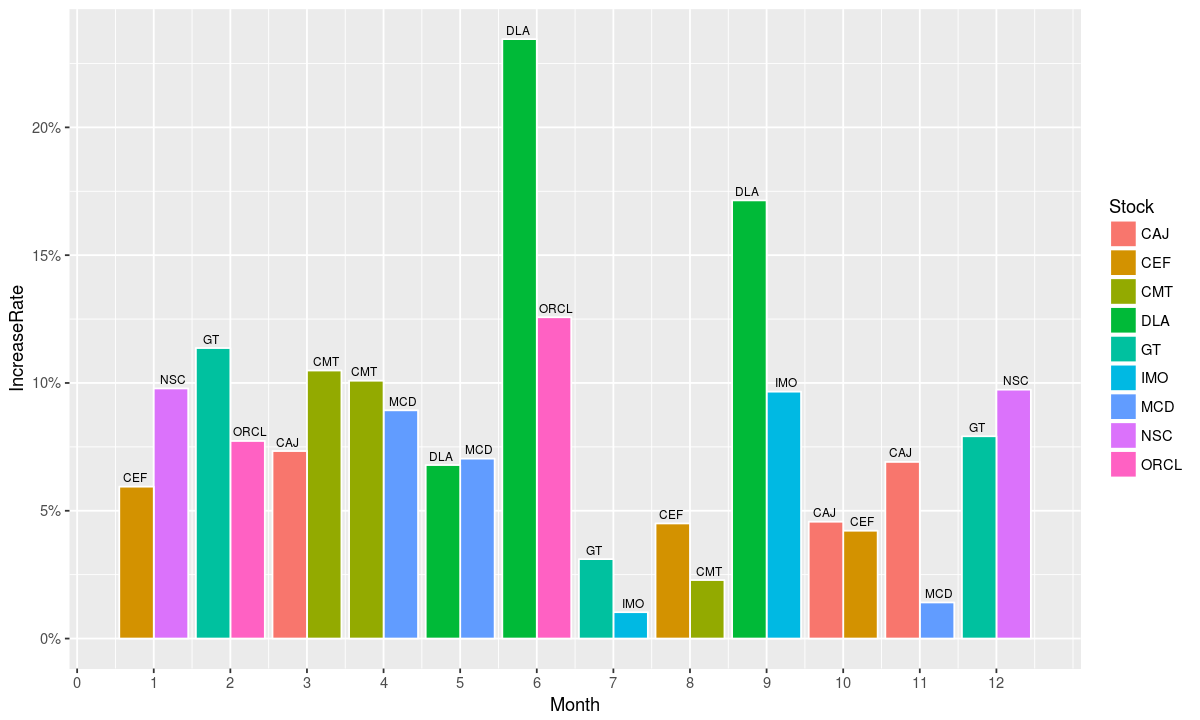

In [38]:
ggplot(data.for.plot) +
    aes(x = monthNum, y = IncreaseRate, fill = Stock) +
    geom_bar(stat = 'identity', position = 'dodge', col="white") +
    geom_text(mapping = aes(label=Stock,
                            vjust = ifelse(IncreaseRate > 0, -0.5, 1)), 
              position = position_dodge(1),
              size = 2.5) +
    scale_y_continuous(labels=scales::percent) +
    scale_x_continuous(breaks = 0:12,
                       limits = c(0.5, 12.5)) +
    xlab("Month")

Top 2 Decrease

In [39]:
data.for.plot = stock.change.monthly %>%
    group_by(monthNum) %>%
    top_n(2, -IncreaseRate) %>%
    ungroup()

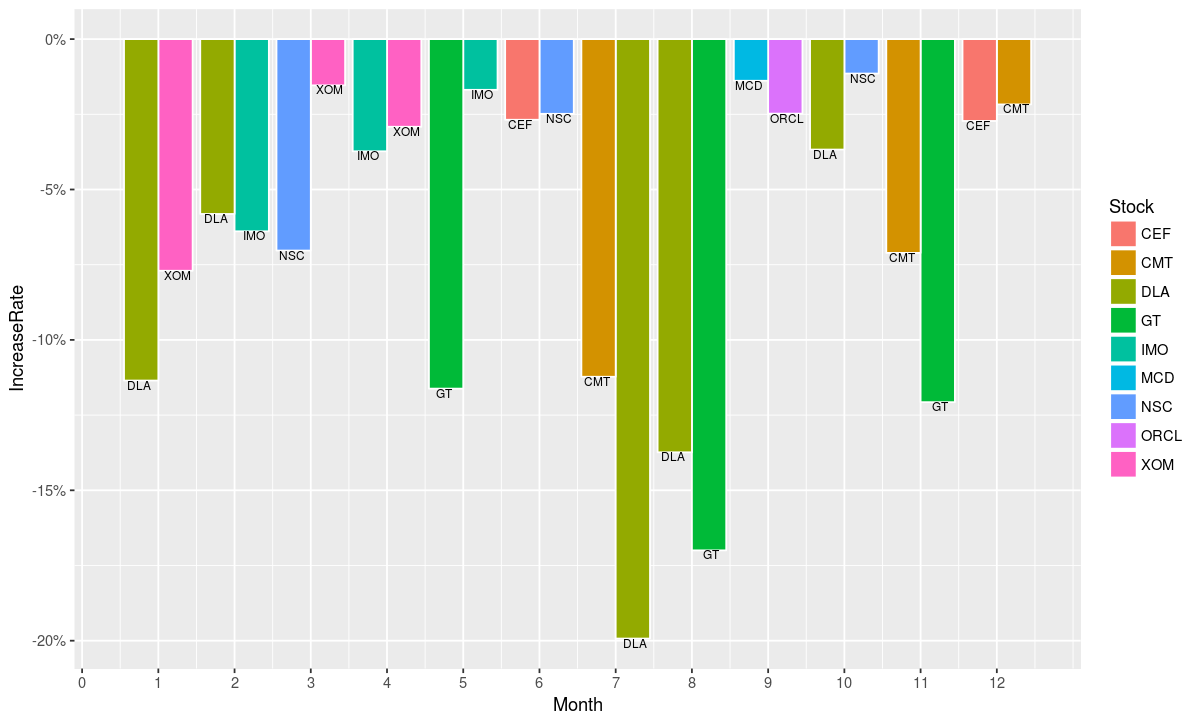

In [40]:
ggplot(data.for.plot) +
    aes(x = monthNum, y = IncreaseRate, fill = Stock) +
    geom_bar(stat = 'identity', position = 'dodge', col="white") +
    geom_text(mapping = aes(label=Stock,
                            vjust = ifelse(IncreaseRate > 0, -0.5, 1)), 
              position = position_dodge(1),
              size = 2.5) +
    scale_y_continuous(labels=scales::percent) +
    scale_x_continuous(breaks = 0:12,
                       limits = c(0.5, 12.5)) +
    xlab("Month")

**Weekly**

In [41]:
stock.change.weekly = stock.trading.close %>%
    group_by(Stock, weekNum) %>%
    summarize(CloseFirst = Price[which.min(Date)]) %>%
    ungroup() %>%
    inner_join(stock.trading.close %>%
               group_by(Stock, weekNum) %>%
               summarize(CloseLast = Price[which.max(Date)]) %>%
               ungroup()) %>%
    mutate(IncreaseRate = (CloseLast - CloseFirst) / CloseFirst) %>%
    arrange(weekNum, -IncreaseRate)
stock.change.weekly

Joining, by = c("Stock", "weekNum")


Stock,weekNum,CloseFirst,CloseLast,IncreaseRate
CEF,1,11.61,11.88,0.023255814
GT,1,31.19,31.84,0.020840013
NSC,1,106.99,109.18,0.020469203
ORCL,1,38.55,39.03,0.012451362
MCD,1,119.62,120.43,0.006771443
⋮,⋮,⋮,⋮,⋮
XOM,47,83.29,82.28,-0.01212631
ORCL,47,49.06,48.42,-0.01304525
CEF,47,13.12,12.87,-0.01905488
GT,47,32.37,31.36,-0.03120173


Plot top 1 stoks each week

In [42]:
data.for.plot = stock.change.weekly %>%
    group_by(weekNum) %>%
    top_n(1, IncreaseRate) %>%
    ungroup() %>%
    bind_rows(stock.change.weekly %>%
    group_by(weekNum) %>%
    top_n(1, -IncreaseRate) %>%
    ungroup())

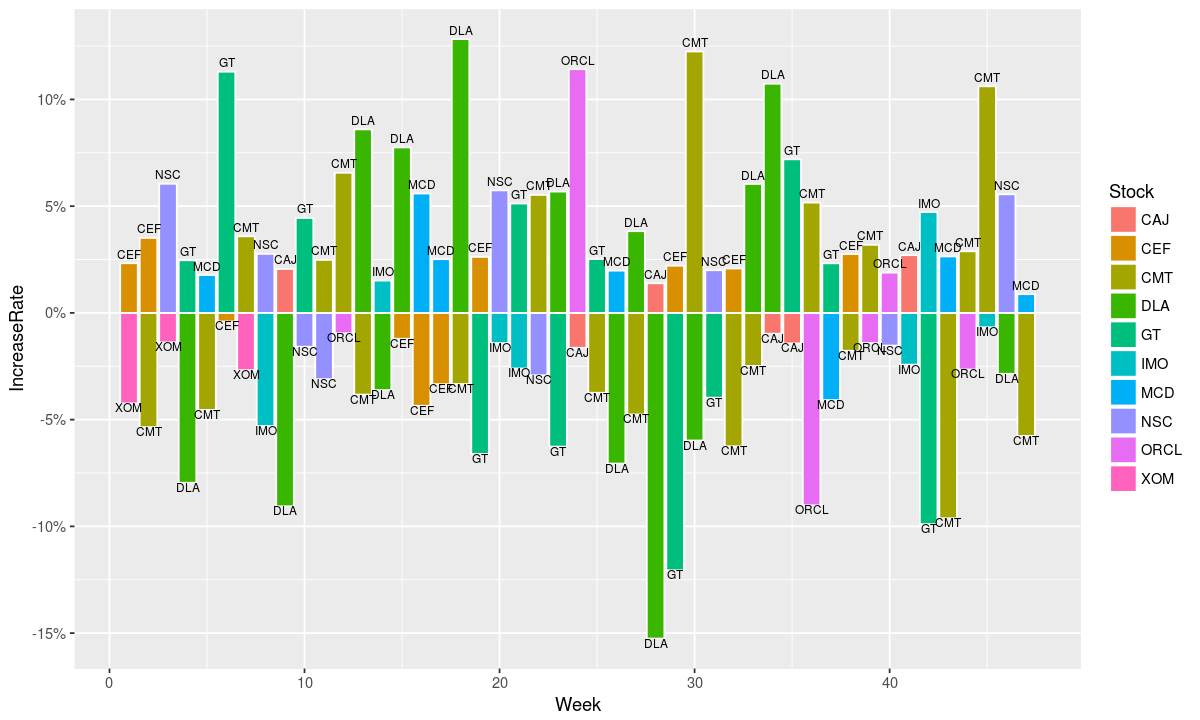

In [43]:
ggplot(data.for.plot) +
    aes(x = weekNum, y = IncreaseRate, fill = Stock) +
    geom_bar(stat = 'identity', col="white") +
    geom_text(mapping = aes(label=Stock,
                            vjust = ifelse(IncreaseRate > 0, -0.5, 1)),
              size = 2.5) +
    scale_y_continuous(labels=scales::percent) +
    xlab("Week")

### Section 3

**What is the probability of rise or fall after continuously rising or falling for a certain amount of days? Consider it over all stocks, stocks in each sector , or several selected stocks seperately.**

For a certain number of days, finding all the cases of continously rising (falling) in previous days, and rising or falling in the last day, then the probability of rise or fall can be computed by Bayesian formula.

$$P(R_{(n + 1)th} | R_{n}) = \frac{P(R_{(n+1)th}, R_{n})}{P(R_{n})} = \frac{P(R_{n+1})}{P(R_{n})} = \frac{n(R_{n+1})}{n(R_{n})}$$

where

- $P(R_{(n+1)th})$ means the probability of rise of a stock on $(n+1)th$ day,
- $P(R_{n})$ means the probability of continously rise of a stock on next $n$ days,
- $n( * )$ just the frequency of each corresponding case, since the denominators for both probabilities above are same - just the frequency of all cases (rise, fall, or not change) in next $n + 1$ days


Use full data starting from this section

In [13]:
sampleSize = 189
sample.stock.trading.data = stock_trading_data %>%
    select(Symbol) %>%
    distinct() %>%
    sample_n(sampleSize) %>%
    inner_join(stock_trading_data)
sample.stock.trading.data

Joining, by = "Symbol"


Symbol,Date,Open,High,Low,Close,Adjusted,Volume,Dividend,SplitCoefficient
FB,2017-12-08,181.53,182.28,178.7401,179.00,179.00,19377310,0,1
FB,2017-12-07,175.80,180.39,175.8000,180.14,180.14,19588217,0,1
FB,2017-12-06,172.50,176.77,171.9000,176.06,176.06,20059293,0,1
FB,2017-12-05,170.45,175.38,169.0100,172.83,172.83,20028656,0,1
FB,2017-12-04,176.29,176.57,170.7900,171.47,171.47,24184006,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HBANO,2016-04-01,25.70,25.7300,25.539,25.63,23.4205,111915,0,1
HBANO,2016-03-31,25.50,25.7224,25.500,25.69,23.4754,145832,0,1
HBANO,2016-03-30,25.59,25.6600,25.450,25.51,23.3109,194020,0,1
HBANO,2016-03-29,25.55,25.7000,25.400,25.58,23.3748,440261,0,1


Compute day difference and close price difference for adjacent data point

In [45]:
stock.trading.diff = sample.stock.trading.data %>%
    select(Symbol, Date, Close) %>%
    group_by(Symbol) %>%
    arrange(Date) %>%
    mutate(Date_next = lead(Date),
           Close_next = lead(Close),
           Date_diff = Date_next - Date,
           Close_diff = Close_next - Close) %>%
    ungroup() %>%
    drop_na()

Count the number of cases that continously rising for `dayNumber` days

In [46]:
count_rise_n = function(stockData, dayNumber) {
    stockData %>%
        group_by(Symbol) %>%
        arrange(Date) %>%
        mutate(continous_day = roll_sum(Date_diff, dayNumber, fill = NA, align = 'left'),
               continous_increase = roll_min(Close_diff, dayNumber, fill = NA, align = 'left')) %>%
        ungroup() %>%
        filter(continous_day == dayNumber, continous_increase > 0) %>%
        nrow()
}   

In [47]:
count_fall_n = function(stockData, dayNumber) {
    stockData %>%
        group_by(Symbol) %>%
        arrange(Date) %>%
        mutate(continous_day = roll_sum(Date_diff, dayNumber, fill = NA, align = 'left'),
               continous_decrease = roll_max(Close_diff, dayNumber, fill = NA, align = 'left')) %>%
        ungroup() %>%
        filter(continous_day == dayNumber, continous_decrease < 0) %>%
        nrow()
}

**Over all stocks**

In [48]:
count.trends = NULL
for (day in 1:10) {
    increaseCount = count_rise_n(stock.trading.diff, day)
    decreaseCount = count_fall_n(stock.trading.diff, day)
    count.trends = bind_rows(count.trends, 
                                data.frame(day = day,
                                           riseCount=increaseCount,
                                           fallCount=decreaseCount))
}
count.trends = count.trends %>%
    filter(riseCount !=0 | fallCount != 0 ) %>%
    mutate(riseNextCount = lead(riseCount),
           fallNextCount = lead(fallCount)) %>%
    drop_na()

In [49]:
count.trends

day,riseCount,fallCount,riseNextCount,fallNextCount
1,36446,33804,12916,11223
2,12916,11223,4231,3405
3,4231,3405,1022,689


Compute the probability

In [50]:
trend.prob = count.trends %>%
    mutate(p_rr = riseNextCount / riseCount,
           p_ff = fallNextCount / fallCount,
           p_fr = 1 - p_rr,
           p_rf = 1 - p_ff)
trend.prob

day,riseCount,fallCount,riseNextCount,fallNextCount,p_rr,p_ff,p_fr,p_rf
1,36446,33804,12916,11223,0.3543873,0.3320021,0.6456127,0.6679979
2,12916,11223,4231,3405,0.3275782,0.3033948,0.6724218,0.6966052
3,4231,3405,1022,689,0.2415505,0.2023495,0.7584495,0.7976505


For each row,

- The **p_rr** means the probability of rise for next day, given continously rising `day` days;
- The **p_ff** means the probability of fall for next day, given continously falling `day` days;
- The **p_fr** means the probability of not rise for next day, given continously rising `day` days;
- The **p_rf** means the probability of not fall for next day, given continously falling `day` days;

We can see the highest probability is the one that given continously falling 3 days, the next day does not fall!!!

**Rank**

Compute the biggest and smallest probability given a certain amount of days.

In [51]:
trend.prob.stats = trend.prob %>%
    select(day, p_rr, p_ff, p_fr, p_rf) %>%
    gather("prob_type", 'value', -day) %>%
    group_by(day) %>%
    summarize(max_prob = prob_type[which.max(value)],
              max_value = max(value),
              min_prob = prob_type[which.min(value)],
              min_value = min(value)) %>%
    ungroup()
trend.prob.stats

day,max_prob,max_value,min_prob,min_value
1,p_rf,0.6679979,p_ff,0.3320021
2,p_rf,0.6966052,p_ff,0.3033948
3,p_rf,0.7976505,p_ff,0.2023495


Over all data, given 1 day, the "falling for one day and not falling for next day" has biggest probability; the falling for one day and continous falling has smallest probability.

**Over Each Sector**

In [52]:
stock.trading.diff.sector = stock.trading.diff %>%
    inner_join(stock_metadata)

Joining, by = "Symbol"


In [53]:
stock.trading.diff.sector

Symbol,Date,Close,Date_next,Close_next,Date_diff,Close_diff,Sector,industry
CCT,2011-06-28,25.50,2011-06-29,25.50,1 days,0.00,Others,Others
CCT,2011-06-29,25.50,2011-06-30,25.50,1 days,0.00,Others,Others
CCT,2011-06-30,25.50,2011-07-01,25.54,1 days,0.04,Others,Others
CCT,2011-07-01,25.54,2011-07-05,25.58,4 days,0.04,Others,Others
CCT,2011-07-05,25.58,2011-07-06,25.59,1 days,0.01,Others,Others
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ISDR,2017-12-07,17.50,2017-12-08,17.50,1 days,0.00,Miscellaneous,Publishing
MNST,2017-12-07,62.30,2017-12-08,63.22,1 days,0.92,Consumer Non-Durables,Beverages (Production/Distribution)
NEE,2017-12-07,158.18,2017-12-08,159.03,1 days,0.85,Public Utilities,Electric Utilities: Central
CHL,2017-12-07,49.16,2017-12-08,49.16,1 days,0.00,Public Utilities,Telecommunications Equipment


In [54]:
count.trends.sector = ddply(stock.trading.diff.sector %>% select(-industry), .(Sector), function(df){
    sectorInfo = as.character(unique(df$Sector))
    message("processing sector ", sectorInfo)
    countTrends = NULL
    for (day in 1:10) {
        increaseCount = count_rise_n(df %>% select(-Sector), day)
        decreaseCount = count_fall_n(df %>% select(-Sector), day)
        countTrends = bind_rows(countTrends, 
                                    data.frame(day = day,
                                               riseCount=increaseCount,
                                               fallCount=decreaseCount))
    }
    countTrends = countTrends %>%
        filter(riseCount !=0 | fallCount != 0 ) %>%
        mutate(riseNextCount = lead(riseCount),
               fallNextCount = lead(fallCount)) %>%
        drop_na()
    countTrends = countTrends %>%
                mutate(Sector = sectorInfo)
    message("finished sector ", sectorInfo)
    countTrends
})
count.trends.sector

processing sector Basic Industries
finished sector Basic Industries
processing sector Capital Goods
finished sector Capital Goods
processing sector Consumer Durables
finished sector Consumer Durables
processing sector Consumer Non-Durables
finished sector Consumer Non-Durables
processing sector Consumer Services
finished sector Consumer Services
processing sector Energy
finished sector Energy
processing sector Finance
finished sector Finance
processing sector Health Care
finished sector Health Care
processing sector Miscellaneous
finished sector Miscellaneous
processing sector Others
finished sector Others
processing sector Public Utilities
finished sector Public Utilities
processing sector Technology
finished sector Technology
processing sector Transportation
finished sector Transportation


day,riseCount,fallCount,riseNextCount,fallNextCount,Sector
1,2776,2674,966,912,Basic Industries
2,966,912,298,266,Basic Industries
3,298,266,73,53,Basic Industries
1,2967,2688,1051,875,Capital Goods
2,1051,875,347,256,Capital Goods
⋮,⋮,⋮,⋮,⋮,⋮
2,1040,872,350,263,Technology
3,350,263,83,50,Technology
1,2280,1986,857,659,Transportation
2,857,659,288,204,Transportation


In [55]:
trend.prob.sector = count.trends.sector %>%
    mutate(p_rr = riseNextCount / riseCount,
           p_ff = fallNextCount / fallCount,
           p_fr = 1 - p_rr,
           p_rf = 1 - p_ff)
trend.prob.sector

day,riseCount,fallCount,riseNextCount,fallNextCount,Sector,p_rr,p_ff,p_fr,p_rf
1,2776,2674,966,912,Basic Industries,0.3479827,0.3410621,0.6520173,0.6589379
2,966,912,298,266,Basic Industries,0.3084886,0.2916667,0.6915114,0.7083333
3,298,266,73,53,Basic Industries,0.2449664,0.1992481,0.7550336,0.8007519
1,2967,2688,1051,875,Capital Goods,0.3542299,0.3255208,0.6457701,0.6744792
2,1051,875,347,256,Capital Goods,0.3301618,0.2925714,0.6698382,0.7074286
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,1040,872,350,263,Technology,0.3365385,0.3016055,0.6634615,0.6983945
3,350,263,83,50,Technology,0.2371429,0.1901141,0.7628571,0.8098859
1,2280,1986,857,659,Transportation,0.3758772,0.3318228,0.6241228,0.6681772
2,857,659,288,204,Transportation,0.3360560,0.3095599,0.6639440,0.6904401


**Rank**

In [56]:
trend.prob.stats.sector = trend.prob.sector %>%
    select(day, Sector, p_rr, p_ff, p_fr, p_rf) %>%
    gather("prob_type", 'value', -one_of(c("day", "Sector"))) %>%
    group_by(Sector, day) %>%
    summarize(max_prob = prob_type[which.max(value)],
              max_value = max(value),
              min_prob = prob_type[which.min(value)],
              min_value = min(value)) %>%
    ungroup()
trend.prob.stats.sector

Sector,day,max_prob,max_value,min_prob,min_value
Basic Industries,1,p_rf,0.6589379,p_ff,0.3410621
Basic Industries,2,p_rf,0.7083333,p_ff,0.2916667
Basic Industries,3,p_rf,0.8007519,p_ff,0.1992481
Capital Goods,1,p_rf,0.6744792,p_ff,0.3255208
Capital Goods,2,p_rf,0.7074286,p_ff,0.2925714
⋮,⋮,⋮,⋮,⋮,⋮
Technology,2,p_rf,0.6983945,p_ff,0.3016055
Technology,3,p_rf,0.8098859,p_ff,0.1901141
Transportation,1,p_rf,0.6681772,p_ff,0.3318228
Transportation,2,p_rf,0.6904401,p_ff,0.3095599


### Section 4

**Objective:** Predict next day's trend (rise or fall) using previous days' price and volume variables. Different day number and variables will be tried

**Plan:** Combine data in the same way as did in question 1. For close price (either one of features can be used ), whether or not rise in the last day with respect to previous one day is used as label. Then a binary classifier (like logistic classifier) can be used to classifier using all stocks' data.

Make two utility functions to set the training data format
- input `stockTradingData`: `sample.stock.trading.data`
- input `period`: maximal day range to shift. 
- output: shift each type of stock prices one day , two day, ... `period` day, and append the columns to original data

In [14]:
time_shift_variables = function(stockTradingData, period) {
    returnTrainData = NULL
    for (day in 1:period) {
        if (is.null(returnTrainData)) {
            returnTrainData = stockTradingData %>%
                select(-one_of(c('Adjusted', 'Dividend', 'SplitCoefficient')))
        }
        trainVarNames = c('Open', 'High', 'Low', 'Close', 'Volume')
        colNamesNewAdded = paste(trainVarNames, day, sep="")

        returnTrainData = returnTrainData %>%
            group_by(Symbol) %>%
            arrange(Date) %>%
            mutate(!!colNamesNewAdded[1] := lead(Open, day),
                   !!colNamesNewAdded[2] := lead(High, day),
                   !!colNamesNewAdded[3] := lead(Low, day),
                   !!colNamesNewAdded[4] := lead(Close, day),
                   !!colNamesNewAdded[5] := lead(Volume, day)) %>%
            ungroup()
    }
    returnTrainData = returnTrainData %>%
        drop_na()
    return(returnTrainData)
}

Use last day `labelVar` price to minus previous day's corresponding price, and create the binary label.

In [15]:
time_shift_binary_label = function(timeShiftData, lastDay, labelVar='Close') {
    returnTrainLabel = NULL
    trainVarNames = c('Open', 'High', 'Low', 'Close', 'Volume')
    lastDayLabels = paste(trainVarNames, lastDay, sep="")
    stringFunc = paste0(labelVar, lastDay, ' - ', labelVar, (lastDay - 1))
    returnTrainLabel = timeShiftData %>%
        mutate_(.dots = setNames(stringFunc, 'Label')) %>%
        select(-one_of(lastDayLabels)) %>%
        mutate(Rise = Label > 0)
    return(returnTrainLabel)
}

Use previous five days' data to predict whether the 6th day's price will rise

Convert data format

In [16]:
daysToUse = 5
stock.binary.label.data = time_shift_binary_label(time_shift_variables(sample.stock.trading.data, daysToUse), daysToUse)
stock.binary.label.data %>% head()

Symbol,Date,Open,High,Low,Close,Volume,Open1,High1,Low1,⋯,Low3,Close3,Volume3,Open4,High4,Low4,Close4,Volume4,Label,Rise
CCT,2011-06-28,25.69,25.70,25.50,25.50,7391,25.50,25.50,25.50,⋯,25.50,25.54,3374,25.59,25.59,25.51,25.58,4792,0.01,TRUE
CCT,2011-06-29,25.50,25.50,25.50,25.50,0,25.56,25.60,25.50,⋯,25.51,25.58,4792,25.54,25.59,25.52,25.59,8354,0.01,TRUE
CCT,2011-06-30,25.56,25.60,25.50,25.50,8948,25.52,25.55,25.50,⋯,25.52,25.59,8354,25.60,25.63,25.55,25.60,11997,-0.04,FALSE
CCT,2011-07-01,25.52,25.55,25.50,25.54,3374,25.59,25.59,25.51,⋯,25.55,25.60,11997,25.55,25.63,25.55,25.56,5393,0.06,TRUE
CCT,2011-07-05,25.59,25.59,25.51,25.58,4792,25.54,25.59,25.52,⋯,25.55,25.56,5393,25.57,25.66,25.57,25.62,9006,0.04,TRUE
CCT,2011-07-06,25.54,25.59,25.52,25.59,8354,25.60,25.63,25.55,⋯,25.57,25.62,9006,25.60,25.66,25.60,25.66,7087,-0.02,FALSE


Join with metadata information: Sector and Industry

In [17]:
stock.binary.label.data = stock.binary.label.data %>%
    inner_join(stock_metadata) %>%
    select(-Label) %>%
    mutate(Sector = as.factor(Sector),
           industry = as.factor(industry))

Joining, by = "Symbol"


Split data

Use last month data as test

In [61]:
train.data = stock.binary.label.data %>%
    filter(Date < '2017-11-01')
test.data = stock.binary.label.data %>%
    filter(Date >= '2017-11-01')

**Logistic Model**

Train logistic model only with price features

In [62]:
lr_model = glm(Rise ~ . - Symbol - Date - Sector - industry, data=train.data,
            family=binomial())
summary(lr_model)


Call:
glm(formula = Rise ~ . - Symbol - Date - Sector - industry, family = binomial(), 
    data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8256  -1.1754   0.9973   1.1783   1.8977  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept) -1.960e-02  7.892e-03  -2.484   0.0130 *
Open         5.207e-04  2.256e-03   0.231   0.8175  
High         1.803e-03  2.737e-03   0.659   0.5100  
Low          3.591e-03  2.476e-03   1.450   0.1471  
Close       -1.659e-03  2.936e-03  -0.565   0.5720  
Volume      -1.694e-09  1.621e-09  -1.045   0.2958  
Open1       -9.824e-04  2.675e-03  -0.367   0.7134  
High1       -3.711e-03  2.793e-03  -1.329   0.1840  
Low1         6.689e-04  2.448e-03   0.273   0.7847  
Close1       3.937e-03  2.958e-03   1.331   0.1833  
Volume1      1.445e-09  1.866e-09   0.775   0.4386  
Open2       -3.996e-04  2.723e-03  -0.147   0.8833  
High2       -3.583e-03  2.866e-03  -1.250   0.2113  
Low2         1.31

Add `Sector` and `Industry` features

In [63]:
lrIncludeMetada_model = glm(Rise ~ . - Symbol - Date, data=train.data,
            family=binomial())
summary(lrIncludeMetada_model)


Call:
glm(formula = Rise ~ . - Symbol - Date, family = binomial(), 
    data = train.data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.703  -1.187   1.030   1.165   1.841  

Coefficients: (7 not defined because of singularities)
                                                                         Estimate
(Intercept)                                                             6.449e-02
Open                                                                    8.575e-04
High                                                                    2.123e-03
Low                                                                     2.475e-03
Close                                                                  -1.317e-03
Volume                                                                 -1.887e-09
Open1                                                                  -6.339e-04
High1                                                                  -3.330e-03
Low1      

In [64]:
test_preds =
    bind_rows(PriceOnly = test.data %>% add_predictions(lr_model),
              PriceSectorIndustry = test.data %>% add_predictions(lrIncludeMetada_model),
              .id="Model")

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

Plot ROC curves

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming FALSE = 0 and TRUE = 1!”

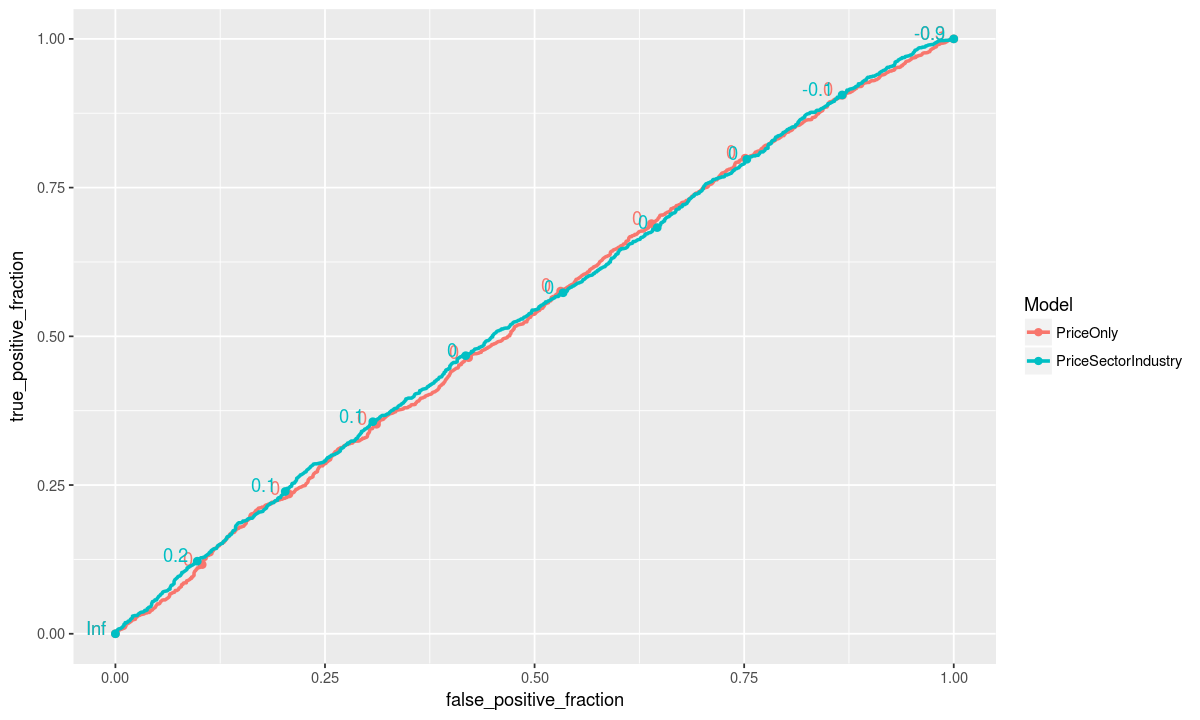

In [65]:
curves = ggplot(test_preds) +
    aes(m=pred, d=Rise, color=Model) +
    geom_roc()
curves

Function to Compute Accuracy

In [66]:
get_accuracy = function(testPreds, threshold) {
    accuracy = testPreds %>%
        mutate(Prediction = (pred - threshold) > 0,
               CorrectPred = Rise == Prediction) %>%
        .$CorrectPred %>%
        mean()
    return(accuracy)
}

Compute accuracy for thresholds

In [67]:
prediction.results = NULL
thresholdToTest = seq(-3, 3, 0.1)
for (threshold in thresholdToTest) {
    prediction.accuracy = ddply(test_preds, .(Model), function(df) {
        modelName = unique(df$Model)
#         message("compute model ", modelName)
        accuracy = get_accuracy(df, threshold)
        data.frame(accuracy = accuracy,
                   threshold = threshold)
    })
    prediction.results = bind_rows(prediction.results, 
                                   prediction.accuracy)
}
prediction.results

Model,accuracy,threshold
PriceOnly,0.5038573,-3.0
PriceSectorIndustry,0.5038573,-3.0
PriceOnly,0.5038573,-2.9
PriceSectorIndustry,0.5038573,-2.9
PriceOnly,0.5038573,-2.8
⋮,⋮,⋮
PriceSectorIndustry,0.4961427,2.8
PriceOnly,0.4961427,2.9
PriceSectorIndustry,0.4961427,2.9
PriceOnly,0.4961427,3.0


Best threshold based on accuracy

In [68]:
best_threshold = prediction.results %>%
    group_by(Model) %>%
    summarize(BestAccuracy = max(accuracy),
              threshold = threshold[which.max(accuracy)])
best_threshold

Model,BestAccuracy,threshold
PriceOnly,0.5185632,0.0
PriceSectorIndustry,0.5214561,-0.1


**Random Forest Model**

Use only price features

In [69]:
rf_model = randomForest(as.factor(Rise) ~ . - Symbol - Date - Sector - industry,
                           data=train.data, 
                           importance=TRUE, 
                           ntree=200)

Include Sector and Industry features

In [70]:
lrIncludeMetada_model = randomForest(as.factor(Rise) ~ . - Symbol - Date - industry,
                           data=train.data, 
                           importance=TRUE,
                           ntree=200)

In [71]:
test_preds_rf = bind_rows(PriceOnly=test.data %>% mutate(Prediction = predict(rf_model, test.data)),
                          PriceSectorIndustry = test.data %>% mutate(Prediction = predict(lrIncludeMetada_model, test.data)),
                          .id = 'Model')
# test_preds_rf

Compute Accuracy

In [72]:
test_preds_rf %>%
    mutate(correctPred = Rise ==Prediction) %>%
    group_by(Model) %>%
    summarize(accuracy = mean(correctPred))

Model,accuracy
PriceOnly,0.5113308
PriceSectorIndustry,0.5139826


Plot importance

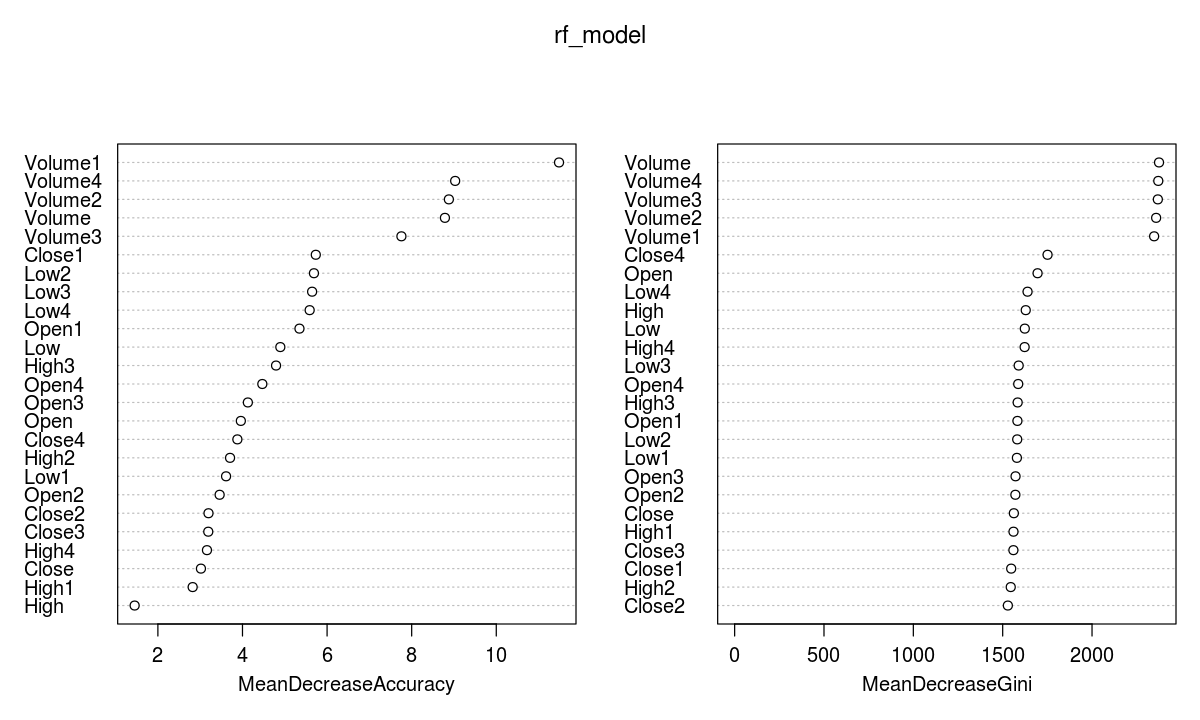

In [73]:
varImpPlot(rf_model)

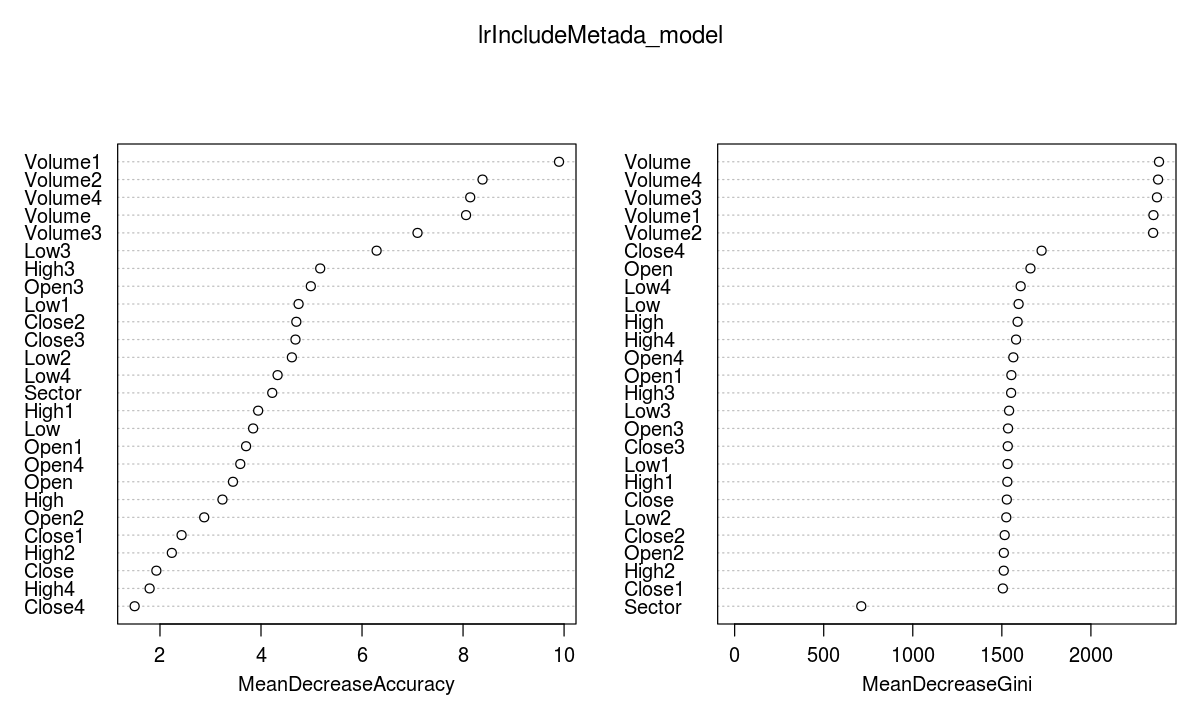

In [74]:
varImpPlot(lrIncludeMetada_model)

The higher value, the more important a variable is.

### Section 5

**Objective:** Predict a day's price using previous adjacent days' features.

**Method:** The same data format as section 5, but a regression model is used to predict the price on the last day.

Utility function to convert last day price value to label

In [18]:
time_shift_label = function(timeShiftData, lastDay, labelVar='Close') {
    returnTrainLabel = NULL
    trainVarNames = c('Open', 'High', 'Low', 'Close', 'Volume')
    lastDayLabels = paste(trainVarNames, lastDay, sep="")
    stringFunc = paste0(labelVar, lastDay)
    returnTrainLabel = timeShiftData %>%
        mutate_(.dots = setNames(stringFunc, 'Label')) %>%
        select(-one_of(lastDayLabels))
    return(returnTrainLabel)
}

Create data

In [19]:
daysToUse = 5
stock.label.data = time_shift_label(time_shift_variables(sample.stock.trading.data, daysToUse), daysToUse)
stock.label.data %>% head()

Symbol,Date,Open,High,Low,Close,Volume,Open1,High1,Low1,⋯,High3,Low3,Close3,Volume3,Open4,High4,Low4,Close4,Volume4,Label
CCT,2011-06-28,25.69,25.70,25.50,25.50,7391,25.50,25.50,25.50,⋯,25.55,25.50,25.54,3374,25.59,25.59,25.51,25.58,4792,25.59
CCT,2011-06-29,25.50,25.50,25.50,25.50,0,25.56,25.60,25.50,⋯,25.59,25.51,25.58,4792,25.54,25.59,25.52,25.59,8354,25.60
CCT,2011-06-30,25.56,25.60,25.50,25.50,8948,25.52,25.55,25.50,⋯,25.59,25.52,25.59,8354,25.60,25.63,25.55,25.60,11997,25.56
CCT,2011-07-01,25.52,25.55,25.50,25.54,3374,25.59,25.59,25.51,⋯,25.63,25.55,25.60,11997,25.55,25.63,25.55,25.56,5393,25.62
CCT,2011-07-05,25.59,25.59,25.51,25.58,4792,25.54,25.59,25.52,⋯,25.63,25.55,25.56,5393,25.57,25.66,25.57,25.62,9006,25.66
CCT,2011-07-06,25.54,25.59,25.52,25.59,8354,25.60,25.63,25.55,⋯,25.66,25.57,25.62,9006,25.60,25.66,25.60,25.66,7087,25.64


Join it with metadata data

In [20]:
stock.label.data = stock.label.data %>%
    inner_join(stock_metadata) %>%
    mutate(Sector = as.factor(Sector),
           industry = as.factor(industry))

Joining, by = "Symbol"


Split data

In [21]:
train.data = stock.label.data %>%
    filter(Date < '2017-11-01')
test.data = stock.label.data %>%
    filter(Date >= '2017-11-01')

### Build Model

**Linear Model**

In [22]:
lasso_model = glmnet(Label ~ . - Symbol - Date - Sector - industry,
                     data=train.data,
                     family="gaussian")
lasso_model

Call:
glmnet.formula(formula = Label ~ . - Symbol - Date - Sector - 
    industry, data = train.data, family = "gaussian")

Model fitting options:
    Sparse model matrix: FALSE
    Use model.frame: FALSE
    Alpha: 1
    Lambda summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.109  16.243  43.096  78.133 114.591 304.034 


In [23]:
lassoIncludeMetaData_model = glmnet(Label ~ . - Symbol - Date,
                     data=train.data,
                     family="gaussian")
lassoIncludeMetaData_model

Call:
glmnet.formula(formula = Label ~ . - Symbol - Date, data = train.data, 
    family = "gaussian")

Model fitting options:
    Sparse model matrix: FALSE
    Use model.frame: FALSE
    Alpha: 1
    Lambda summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.109  16.243  43.096  78.133 114.591 304.034 


Compute RMSE

In [24]:
get_rmse = function(actual, pred) {
    computedRMSE = sqrt(mean((actual - pred)^2))
    return(computedRMSE)
}

Basic lasso model

In [25]:
lasso_rmse = purrr::map_df(lasso_model$lambda, function(l) {
    preds = predict(lasso_model, train.data, s=l)[[1]]
    rmseValue = get_rmse(train.data$Label, preds)
    data.frame(lambda=l, rmse=rmseValue)
})

In [26]:
lassoBestRMSE = lasso_rmse %>%
    mutate(Model = 'lasso') %>%
    group_by(Model) %>%
    summarize(bestLambda = lambda[which.min(rmse)],
              bestRMSE = min(rmse))
lassoBestRMSE

Model,bestLambda,bestRMSE
lasso,304.0338,304.0956


Model with sector and industry information

In [27]:
lasso_meta_rmse = purrr::map_df(lassoIncludeMetaData_model$lambda, function(l) {
    preds = predict(lassoIncludeMetaData_model, train.data, s=l)[[1]]
    rmseValue = get_rmse(train.data$Label, preds)
    data.frame(lambda=l, rmse=rmseValue)
})

In [28]:
lassoMetaBestRMSE = lasso_meta_rmse %>%
    mutate(Model = 'lassoIncludeMeta') %>%
    group_by(Model) %>%
    summarize(bestLambda = lambda[which.min(rmse)],
              bestRMSE = min(rmse))
lassoMetaBestRMSE

Model,bestLambda,bestRMSE
lassoIncludeMeta,304.0338,304.0956


Bind data

In [29]:
test_preds_lasso = bind_rows(PriceOnly = test.data %>% 
                                 mutate(pred = predict(lasso_model, test.data, s=lassoBestRMSE$bestLambda)),
                             PriceSectorIndustry = test.data %>% 
                                 mutate(pred = predict(lassoIncludeMetaData_model, test.data, s=lassoMetaBestRMSE$bestLambda)),
                             .id = "Model")
test_preds_lasso

Model,Symbol,Date,Open,High,Low,Close,Volume,Open1,High1,⋯,Volume3,Open4,High4,Low4,Close4,Volume4,Label,Sector,industry,pred
PriceOnly,FB,2017-11-01,182.36,182.90,180.57,182.66,28922959,180.63,181.940,⋯,13065077,180.50,180.75,178.96,180.25,12679885,179.56,Technology,"Computer Software: Programming, Data Processing",101.537
PriceOnly,UTX,2017-11-01,120.55,121.00,119.93,120.12,2666834,120.09,121.510,⋯,2225963,120.67,121.46,120.38,120.75,1853601,120.28,Capital Goods,Aerospace,101.537
PriceOnly,FANG,2017-11-01,108.23,111.71,108.14,109.78,1331731,109.37,109.940,⋯,1612738,114.82,114.93,111.15,111.80,2002340,110.04,Energy,Oil & Gas Production,101.537
PriceOnly,PYPL,2017-11-01,72.78,72.99,71.69,72.38,6576235,72.46,72.776,⋯,10052359,75.17,75.45,74.19,74.41,6855004,74.77,Miscellaneous,Business Services,101.537
PriceOnly,MSFT,2017-11-01,83.68,83.76,82.88,83.18,22039635,83.35,84.460,⋯,19039847,84.77,84.90,83.93,84.27,17152583,84.56,Technology,Computer Software: Prepackaged Software,101.537
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PriceSectorIndustry,UNH,2017-12-01,228.89,229.2200,221.081,226.78,3326098,229.26,231.77,⋯,2390893,220.59,220.61,218.1900,220.15,2658247,223.91,Health Care,Medical Specialities,101.537
PriceSectorIndustry,GE,2017-12-01,18.28,18.2800,17.860,17.88,82027614,18.00,18.06,⋯,43374084,17.66,18.06,17.6300,17.71,55419450,17.71,Energy,Consumer Electronics/Appliances,101.537
PriceSectorIndustry,GOOGL,2017-12-01,1030.41,1037.2400,1016.900,1025.07,1866985,1027.80,1031.34,⋯,1369276,1036.07,1048.92,1035.3600,1044.57,1437448,1049.38,Technology,"Computer Software: Programming, Data Processing",101.537
PriceSectorIndustry,HBANO,2017-12-01,27.56,27.7502,27.500,27.67,18345,27.47,27.94,⋯,76977,28.15,28.27,28.1500,28.27,23169,28.57,Finance,Major Banks,101.537


RMSE on test data

In [30]:
test_preds_lasso %>%
    group_by(Model) %>%
    summarize(rmse = get_rmse(Label, pred)) %>%
    ungroup()

Model,rmse
PriceOnly,358.4687
PriceSectorIndustry,358.4687


Find top 1 accuracy stock, and plot it

In [31]:
test_preds_lasso %>%
    group_by(Model, Symbol) %>%
    summarize(rmse = get_rmse(Label, pred)) %>%
    ungroup() %>%
    group_by(Model) %>%
    top_n(1, -rmse)

Model,Symbol,rmse
PriceOnly,CELG,2.030962
PriceSectorIndustry,CELG,2.030962


Compute data for plot

In [32]:
results.for.plot = test_preds_lasso %>% filter(Symbol == "CELG") %>%
    select(Model, Symbol, Date, Label, pred) %>%
    gather("Var", 'Value', one_of(c('Label', 'pred')))

Plot it

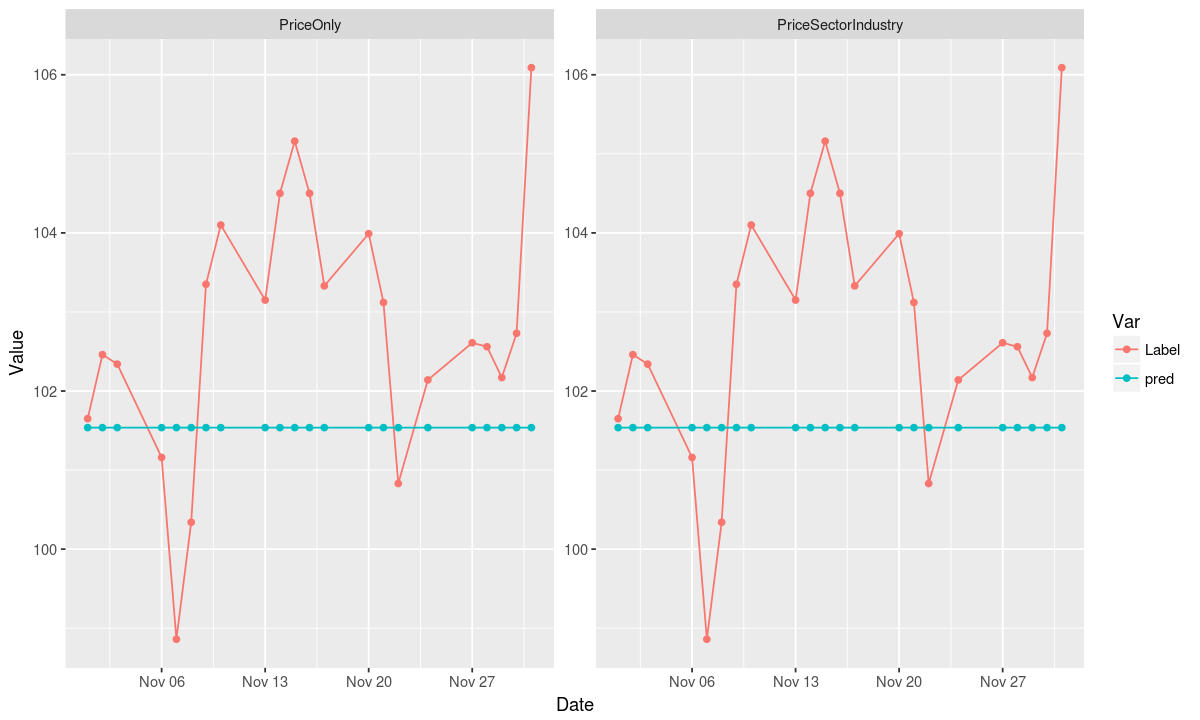

In [166]:
ggplot(results.for.plot) +
    aes(x=Date, y = Value, color = Var) +
    geom_point() +
    geom_line() +
    facet_wrap(~Model, scales = 'free')

Cross validation

In [33]:
lasso_model_cross_val = cv.glmnet(Label ~ . - Symbol - Date,
                     data=train.data,
                     family="gaussian")

lassoIncludeMetaData_model_cross_val = cv.glmnet(Label ~ . - Symbol - Date,
                     data=train.data,
                     family="gaussian")

In [34]:
test_preds_lasso = bind_rows(PriceOnly = test.data %>% 
                                 mutate(pred = predict(lasso_model, test.data, s=lasso_model_cross_val$lambda.min)),
                             PriceSectorIndustry = test.data %>% 
                                 mutate(pred = predict(lassoIncludeMetaData_model, test.data, s=lassoIncludeMetaData_model_cross_val$lambda.min)),
                             .id = "Model")
# test_preds_lasso

In [35]:
test_preds_lasso %>%
    group_by(Model, Symbol) %>%
    summarize(rmse = get_rmse(Label, pred)) %>%
    ungroup() %>%
    group_by(Model) %>%
    top_n(1, -rmse)

Model,Symbol,rmse
PriceOnly,VCIT,0.2669452
PriceSectorIndustry,VCIT,0.2669452


In [171]:
results.for.plot = test_preds_lasso %>% filter(Symbol == "VCIT") %>%
    select(Model, Symbol, Date, Label, pred) %>%
    gather("Var", 'Value', one_of(c('Label', 'pred')))

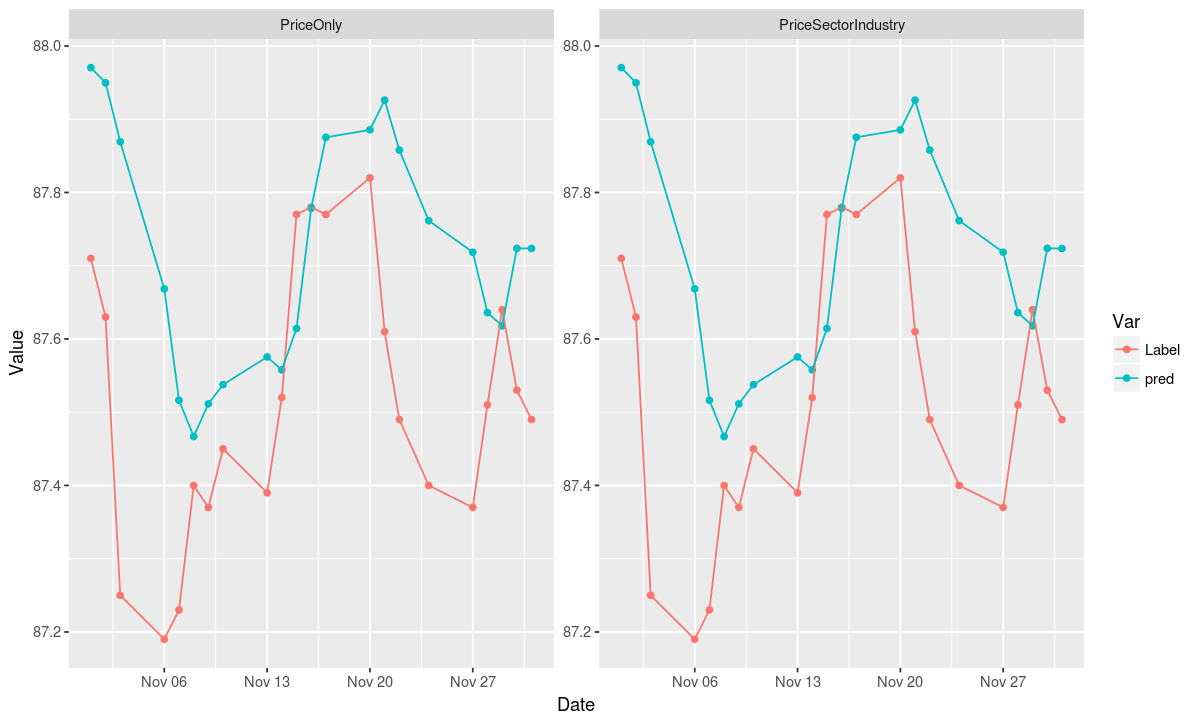

In [172]:
ggplot(results.for.plot) +
    aes(x=Date, y = Value, color = Var) +
    geom_point() +
    geom_line() +
    facet_wrap(~Model, scales = 'free')

**Random Forest**

In [20]:
train.data %>%
    nrow()

[1] 87472

In [36]:
rf_model = randomForest(Label ~ . - Symbol - Date - Sector - industry,
                           data=train.data, 
                           importance=FALSE,
                           nodesize=20,
                           maxnodes=256,
                           ntree=200)

In [37]:
lrIncludeMetada_model = randomForest(Label ~ . - Symbol - Date - industry,
                           data=train.data, 
                           importance=FALSE,
                           nodesize=20,
                           maxnodes=256, 
                           ntree=200)

In [38]:
test_preds_rf = bind_rows(PriceOnly=test.data %>% mutate(pred = predict(rf_model, test.data)),
                          PriceSectorIndustry = test.data %>% mutate(pred = predict(lrIncludeMetada_model, test.data)),
                          .id = 'Model')

RMSE

In [39]:
test_preds_rf %>%
    group_by(Model) %>%
    summarize(rmse = get_rmse(Label, pred)) %>%
    ungroup()

Model,rmse
PriceOnly,5.975770
PriceSectorIndustry,6.100396


Top 1 predictive stock

In [40]:
test_preds_rf %>%
    group_by(Model, Symbol) %>%
    summarize(rmse = get_rmse(Label, pred)) %>%
    ungroup() %>%
    group_by(Model) %>%
    top_n(1, -rmse)

Model,Symbol,rmse
PriceOnly,DNP,0.05353517
PriceSectorIndustry,DNP,0.04580475


In [43]:
results.for.plot = test_preds_lasso %>% filter(Symbol == "DNP") %>%
    select(Model, Symbol, Date, Label, pred) %>%
    gather("Var", 'Value', one_of(c('Label', 'pred')))

Plot it

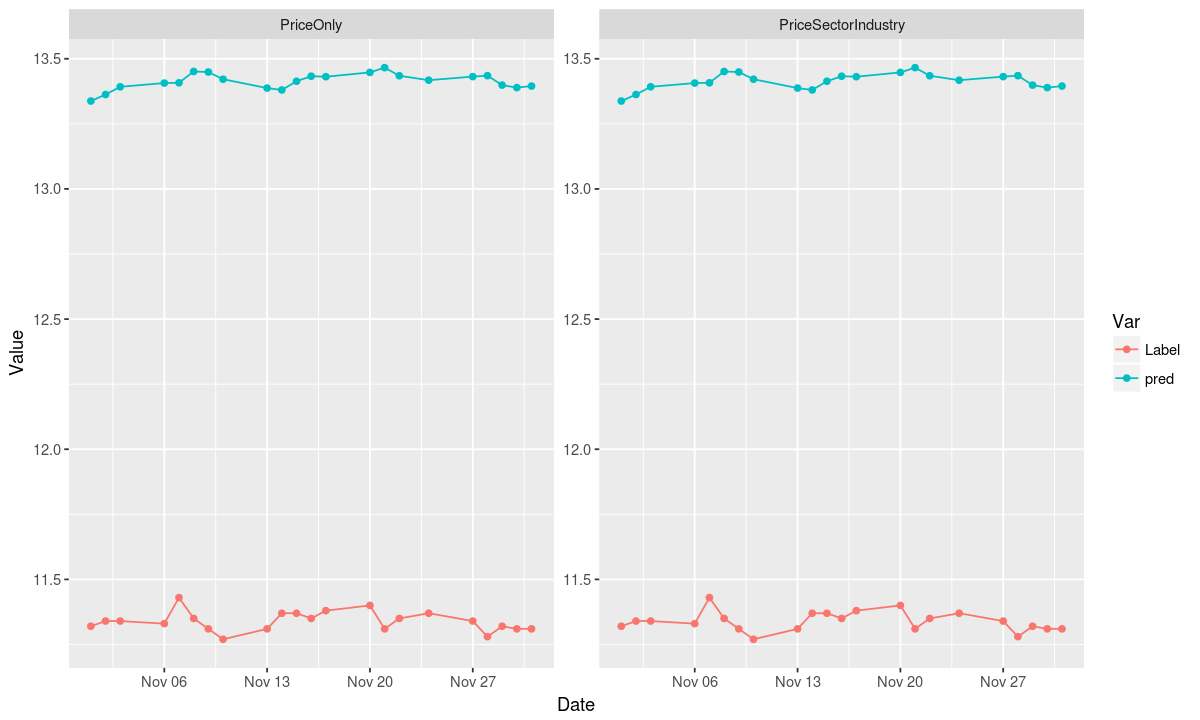

In [44]:
ggplot(results.for.plot) +
    aes(x=Date, y = Value, color = Var) +
    geom_point() +
    geom_line() +
    facet_wrap(~Model, scales = 'free')